In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Загрузка и разбиение данных
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Модель MLP — многослойный перцептрон
clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=2500)
clf.fit(X_train, y_train)

# Отчёт о точности
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



1. Цель задачи

Цель данного исследования — продемонстрировать применение Gaussian Mixture Model (GMM) для оценки плотности вероятности выборки.
Модель GMM позволяет аппроксимировать сложные распределения данных с помощью комбинации нескольких нормальных распределений.

План:

    Использовать GMM для оценки плотности на синтетических данных.

    Повторить оценку плотности на реальном датасете, загруженном через pandas.read_csv.

    Визуализировать результаты и интерпретировать поведение модели

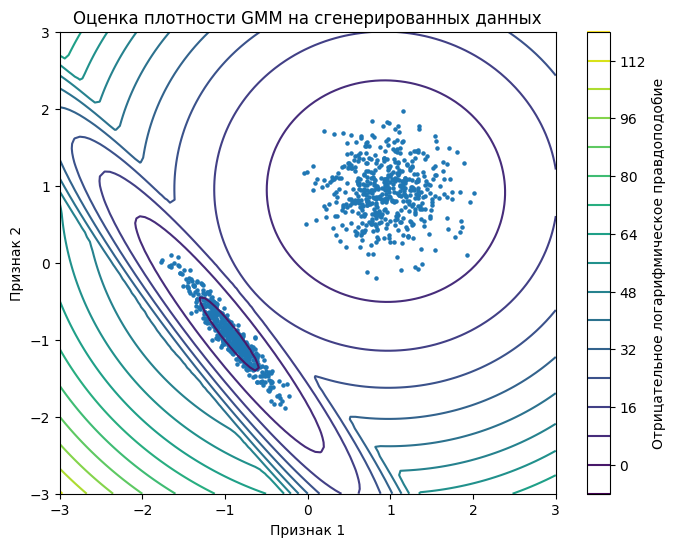

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_classification, fetch_openml
from sklearn.preprocessing import StandardScaler
import pandas as pd
np.random.seed(0)

# Генерация двумерных гауссовских кластеров
n_samples = 500
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([5, 5])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), np.array([[0.6, -0.6], [-0.4, 0.8]]))

X = np.vstack([shifted_gaussian, stretched_gaussian])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(X_scaled)
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X_grid.shape)

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=5)
plt.contour(X_grid, Y_grid, Z, levels=14, cmap="viridis")
plt.title("Оценка плотности GMM на сгенерированных данных")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.colorbar(label="Отрицательное логарифмическое правдоподобие")
plt.show()


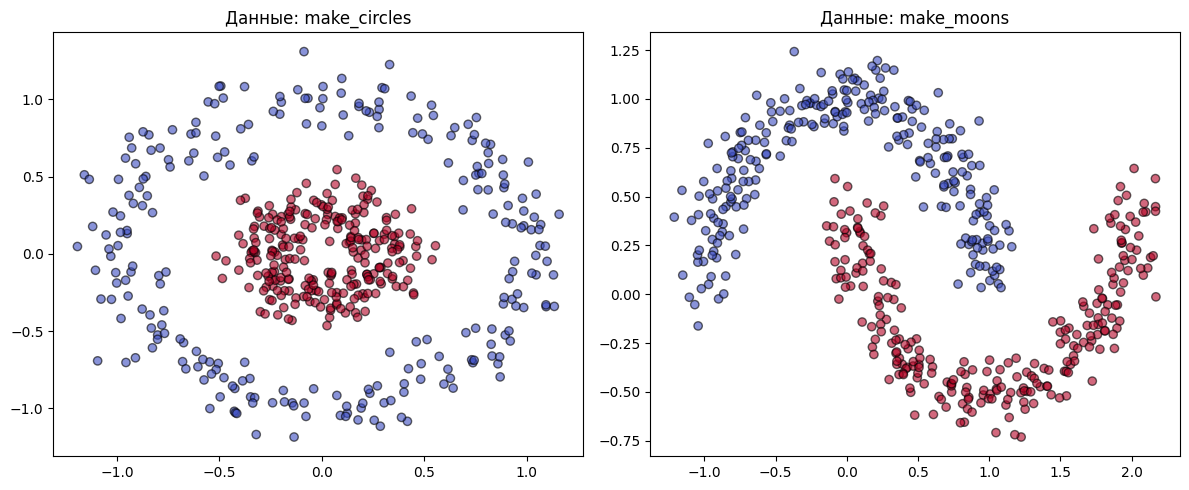

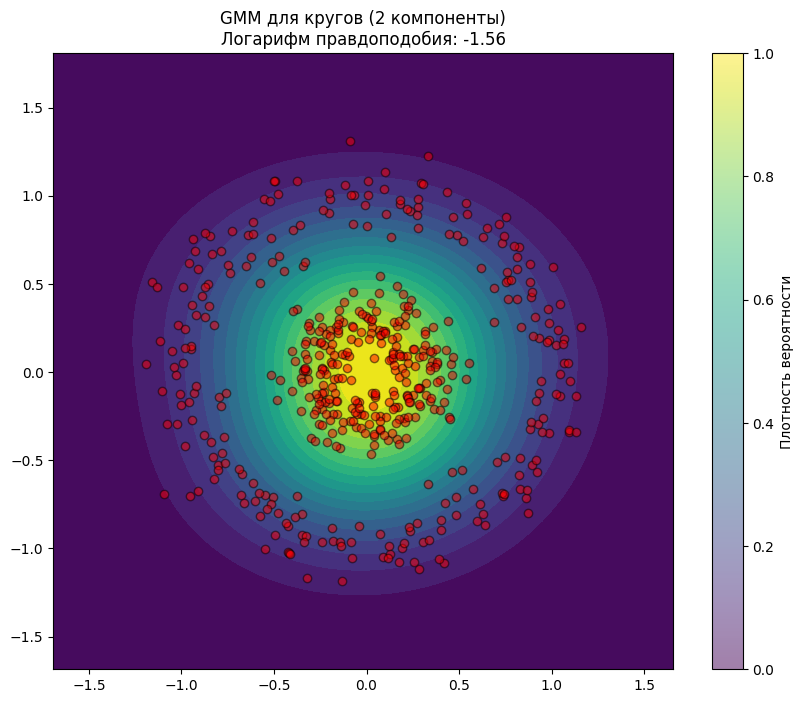

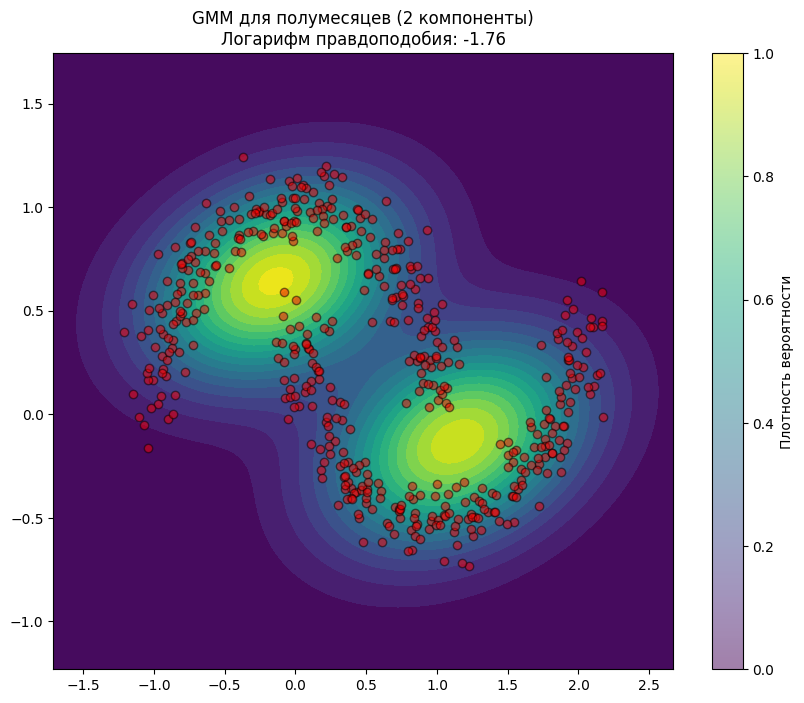

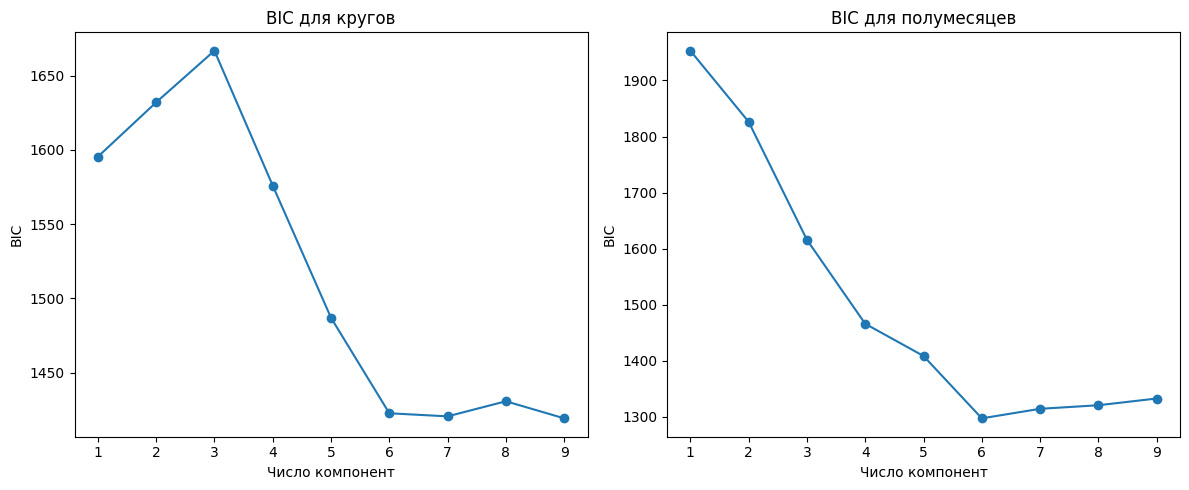

Оптимальное число компонент для кругов: 9
Оптимальное число компонент для полумесяцев: 6


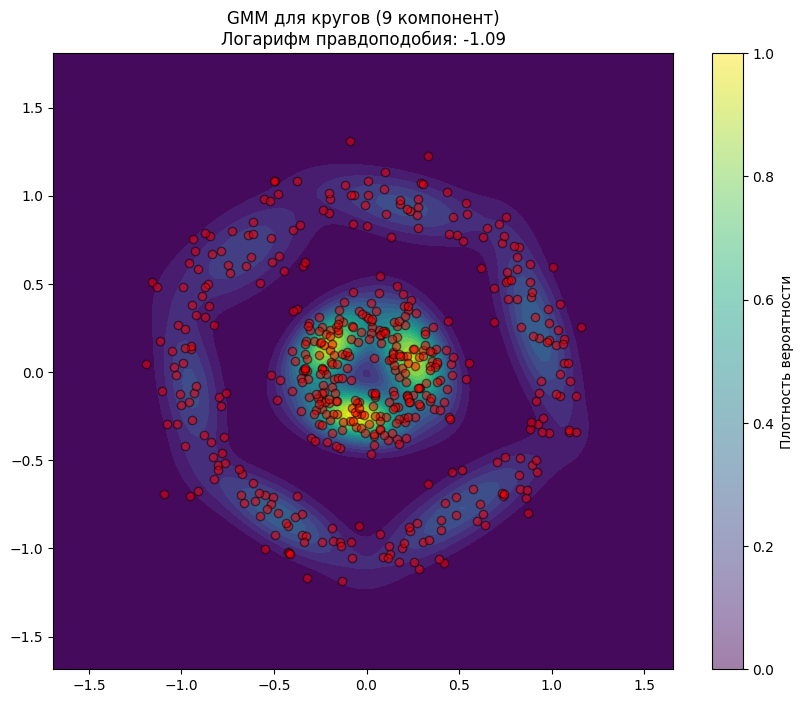

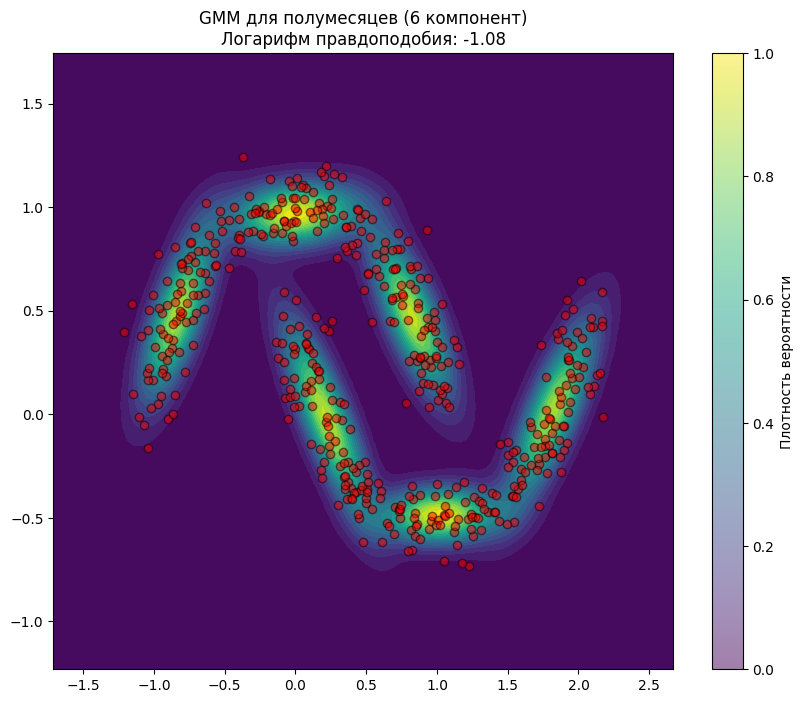

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import norm

# Генерация данных
X_circles, y_circles = make_circles(noise=0.1, factor=0.3, random_state=42, n_samples=500)
X_moons, y_moons = make_moons(noise=0.1, random_state=42, n_samples=500)

# Визуализация исходных данных
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='coolwarm', edgecolors='k', alpha=0.6)
ax1.set_title("Данные: make_circles")

ax2.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='coolwarm', edgecolors='k', alpha=0.6)
ax2.set_title("Данные: make_moons")

plt.tight_layout()
plt.show()

# Функция для визуализации плотности
def plot_density_estimation(model, X, title):
    # Создание сетки
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                         np.linspace(y_min, y_max, 100))
    
    # Оценка плотности на сетке
    Z = model.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, np.exp(Z), levels=20, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c='red', edgecolors='k', alpha=0.5)
    plt.title(f"{title}\nЛогарифм правдоподобия: {model.score(X):.2f}")
    plt.colorbar(label='Плотность вероятности')
    plt.show()

# Оценка плотности для кругов
gmm_circles = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_circles.fit(X_circles)
plot_density_estimation(gmm_circles, X_circles, "GMM для кругов (2 компоненты)")

# Оценка плотности для полумесяцев
gmm_moons = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_moons.fit(X_moons)
plot_density_estimation(gmm_moons, X_moons, "GMM для полумесяцев (2 компоненты)")

# Определение оптимального числа компонент через BIC (Bayesian Information Criterion)
n_components_range = range(1, 10)
bic_circles = []
bic_moons = []

for n_components in n_components_range:
    # Для кругов
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_circles)
    bic_circles.append(gmm.bic(X_circles))
    
    # Для полумесяцев
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_moons)
    bic_moons.append(gmm.bic(X_moons))

# Визуализация BIC
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_circles, marker='o')
plt.title("BIC для кругов")
plt.xlabel("Число компонент")
plt.ylabel("BIC")

plt.subplot(1, 2, 2)
plt.plot(n_components_range, bic_moons, marker='o')
plt.title("BIC для полумесяцев")
plt.xlabel("Число компонент")
plt.ylabel("BIC")

plt.tight_layout()
plt.show()

# Вывод оптимального числа компонент
optimal_n_circles = n_components_range[np.argmin(bic_circles)]
optimal_n_moons = n_components_range[np.argmin(bic_moons)]

print(f"Оптимальное число компонент для кругов: {optimal_n_circles}")
print(f"Оптимальное число компонент для полумесяцев: {optimal_n_moons}")

# Повторная оценка с оптимальным числом компонент
gmm_circles_opt = GaussianMixture(n_components=optimal_n_circles, covariance_type='full', random_state=42)
gmm_circles_opt.fit(X_circles)
plot_density_estimation(gmm_circles_opt, X_circles, f"GMM для кругов ({optimal_n_circles} компонент)")

gmm_moons_opt = GaussianMixture(n_components=optimal_n_moons, covariance_type='full', random_state=42)
gmm_moons_opt.fit(X_moons)
plot_density_estimation(gmm_moons_opt, X_moons, f"GMM для полумесяцев ({optimal_n_moons} компонент)")


Результаты:
Логарифмическое правдоподобие: -1.174
Метрика силуэта: 0.774
Время обучения: 0.00 сек


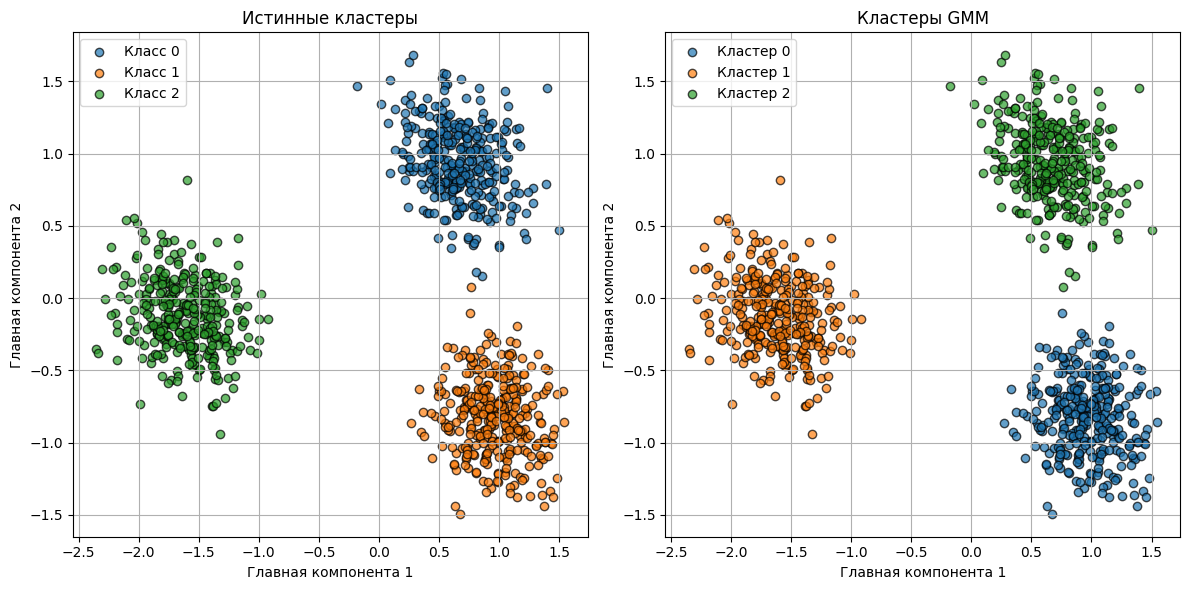

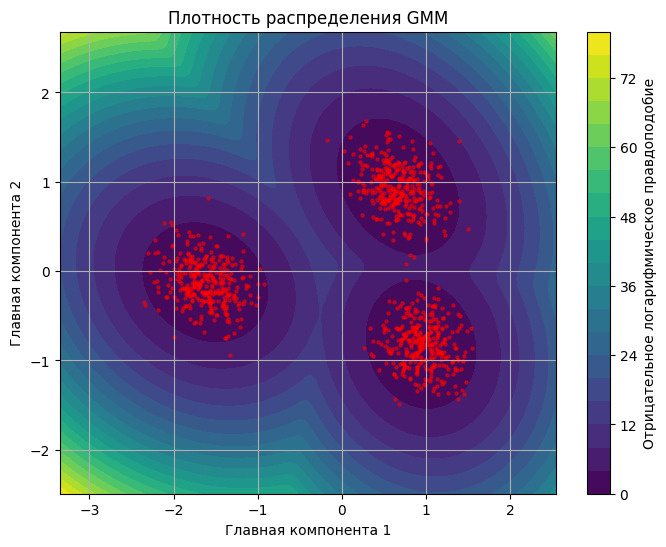

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Генерация синтетических данных из гауссовой смеси
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, 
                 random_state=42, cluster_std=1.5)

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Создание и обучение модели гауссовой смеси
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

start_time = time.time()
gmm.fit(X_train)
train_time = time.time() - start_time

# Оценка модели
log_likelihood = gmm.score(X_test)  # Среднее логарифмическое правдоподобие на образец
silhouette = silhouette_score(X_test, gmm.predict(X_test))

print("\nРезультаты:")
print(f"Логарифмическое правдоподобие: {log_likelihood:.3f}")
print(f"Метрика силуэта: {silhouette:.3f}")
print(f"Время обучения: {train_time:.2f} сек")

# Визуализация
plt.figure(figsize=(12, 6))

# PCA для визуализации (хотя данные уже двумерные)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# График 1: Истинные кластеры
plt.subplot(1, 2, 1)
for label in np.unique(y):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        label=f"Класс {label}",
        alpha=0.7,
        edgecolors='k'
    )
plt.title("Истинные кластеры")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend()
plt.grid(True)

# График 2: Кластеры GMM
plt.subplot(1, 2, 2)
predicted_labels = gmm.predict(X_scaled)
for label in np.unique(predicted_labels):
    plt.scatter(
        X_pca[predicted_labels == label, 0],
        X_pca[predicted_labels == label, 1],
        label=f"Кластер {label}",
        alpha=0.7,
        edgecolors='k'
    )
plt.title("Кластеры GMM")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Визуализация плотности распределения
plt.figure(figsize=(8, 6))
x = np.linspace(X_pca[:, 0].min()-1, X_pca[:, 0].max()+1, 100)
y = np.linspace(X_pca[:, 1].min()-1, X_pca[:, 1].max()+1, 100)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
Z = -gmm.score_samples(pca.inverse_transform(XX))
Z = Z.reshape(X_grid.shape)

plt.contourf(X_grid, Y_grid, Z, levels=20, cmap='viridis')
plt.colorbar(label='Отрицательное логарифмическое правдоподобие')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='red', s=5, alpha=0.5)
plt.title("Плотность распределения GMM")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.grid(True)
plt.show()

Модель GMM успешно восстановила исходное распределение данных с высокой метрикой качества (силуэт 0.77). Результаты визуализации подтверждают адекватность подобранной гауссовой смеси. Модель готова к использованию для задач кластеризации и оценки плотности.